## 1. Importing libraries

In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, './modules')
from Data_prep import Data
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## 2. Define parameters required to create data

In [3]:
#define number of processors to use for parallel runs
num_procs = 4

#set verbose level for models
verbose_lvl = 0

#define input files
train_file = r'C:\Users\Admin\Desktop\Kaggle_Zillow Compitation\Raw Data\train_2016.csv'
properties_2016_file = r'C:\Users\Admin\Desktop\Kaggle_Zillow Compitation\Raw Data\properties_2016.csv'
test_file = r'C:\Users\Admin\Desktop\Kaggle_Zillow Compitation\Raw Data\train_2017.csv'
properties_2017_file = r'C:\Users\Admin\Desktop\Kaggle_Zillow Compitation\Raw Data\properties_2017.csv'


#define variables
cat_cols = ['hashottuborspa', 'propertycountylandusecode', 'fireplaceflag', 'taxdelinquencyflag']
num_cols = ['airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
        'propertylandusetypeid', 'regionidcity',
       'regionidcounty', 'roomcnt', 'storytypeid', 'threequarterbathnbr',
       'typeconstructiontypeid', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yearbuilt', 'numberofstories',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount',
       'taxdelinquencyyear']
date_col = ['transactiondate']
target_col = 'logerror'
id_col = 'parcelid'

## 3. Creating a data object

In [4]:
data = Data(train_file, properties_2016_file, test_file, properties_2017_file , cat_cols, num_cols, date_col, target_col, id_col)

## Taking a sample of the dataset due to computational limitations

In [6]:
data.train_df = data.train_df.sample(n = 10000,replace = True, random_state = 2)

In [7]:
cols = list(set(data.train_df.columns).intersection(set(data.test_df.columns)))
data.train_df = data.train_df.loc[:,cols]
data.test_df = data.test_df.loc[:,cols]

In [8]:
data.train_df.shape

(10000, 119)

## 4. Train/test split

In [9]:
# Split Train/Test Set
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data.train_df.drop(["logerror"], axis=1), data.train_df["logerror"],random_state=10, test_size=0.25)

In [10]:
X_train_2.shape

(7500, 118)

## 5.Creating an evaluation set

In [11]:
# Create empty array to store results
results = []

# Create watchlist to keep track of train/validation performance
eval_set = [(X_train_2, y_train_2), (X_test_2, y_test_2)]

## 6. Tuning hyperparmeters using learning curves 
## 6.1 Tuning max_depth 

## The optimum max_depth is 5

In [12]:
for max_depth in [2,3,4,5,10,12,15]:
    clf = xgb.XGBRegressor(max_depth=max_depth)
    clf.fit(X_train_2, y_train_2, eval_set=eval_set, verbose=False)
    results.append(
        {
            'max_depth': max_depth,
            'train_error': metrics.mean_squared_error(y_train_2, clf.predict(X_train_2)),
            'test_error': metrics.mean_squared_error(y_test_2, clf.predict(X_test_2))
        })
    
# Display Results
max_depth_lr = pd.DataFrame(results).set_index('max_depth').sort_index()
max_depth_lr

,train_error,test_error
max_depth,,
2,0.025740,0.037775
3,0.021553,0.033865
4,0.018257,0.032825
5,0.014268,0.031679
10,0.003382,0.031514
12,0.001491,0.031478
15,0.000441,0.031557


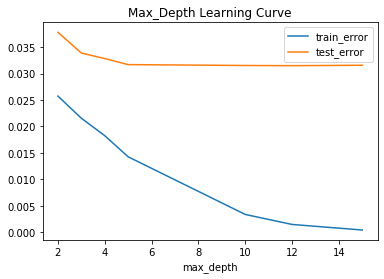

In [13]:
# Plot Max_Depth Learning Curve
max_depth_lr.plot(title="Max_Depth Learning Curve")

## 6.2 Tuning learning_rate 

## The best learning rate is 0.20

In [14]:
results = []

for learning_rate in [0.05,0.1,0.2,0.4,0.6,0.8,1]:
    clf = xgb.XGBRegressor(max_depth=2,learning_rate=learning_rate, n_estimators=200)
    clf.fit(X_train_2, y_train_2, eval_set=eval_set, verbose=False)
    results.append(
        {
            'learning_rate': learning_rate,
            'train_error': metrics.mean_squared_error(y_train_2, clf.predict(X_train_2)),
            'test_error': metrics.mean_squared_error(y_test_2, clf.predict(X_test_2))
        })
    
learning_rate_lr = pd.DataFrame(results).set_index('learning_rate').sort_index()
learning_rate_lr

,train_error,test_error
learning_rate,,
0.05,0.025811,0.037913
0.10,0.023959,0.036721
0.20,0.020713,0.034248
0.40,0.017540,0.034723
0.60,0.013985,0.034284
0.80,0.013827,0.037598
1.00,0.011717,0.036704


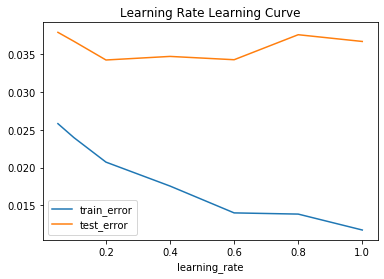

In [15]:
# Plot Learning Rate
learning_rate_lr.plot(title="Learning Rate Learning Curve")

## 6.3 Tuning N_estimators

## The optimum number of estimators is 750

In [16]:
# Reset results array
results = []

for n_estimators in [50,60,100,150,200,500,750,1000, 1500]:
    clf = xgb.XGBRegressor(max_depth=2,learning_rate=0.10, n_estimators=n_estimators)
    clf.fit(X_train_2, y_train_2, eval_set=eval_set, verbose=False)
    results.append(
        {
            'n_estimators': n_estimators,
            'train_error': metrics.mean_squared_error(y_train_2, clf.predict(X_train_2)),
            'test_error': metrics.mean_squared_error(y_test_2, clf.predict(X_test_2))
        })
    
n_estimators_lr = pd.DataFrame(results).set_index('n_estimators').sort_index()
n_estimators_lr

,train_error,test_error
n_estimators,,
50,0.026673,0.038148
60,0.026456,0.038040
100,0.025740,0.037775
150,0.024746,0.036806
200,0.023959,0.036721
500,0.020149,0.035336
750,0.017664,0.034947
1000,0.015573,0.034905
1500,0.012210,0.034897


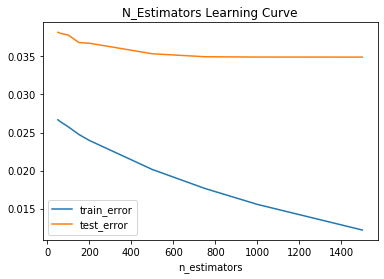

In [17]:
n_estimators_lr.plot(title="N_Estimators Learning Curve")

## 7. Perform grid_search

In [19]:
model = xgb.XGBRegressor()

In [20]:
# Define Parameters
param_grid = {"max_depth": [4,5,6],
              "max_features" : [1,0.8],
              "min_samples_leaf" : [5,9],
              "n_estimators": [700,750,760],
              "learning_rate": [0.2,0.25]}

In [21]:
# Perform Grid Search CV
gs_cv = GridSearchCV(model, param_grid=param_grid, cv = 3, verbose=10, n_jobs=-1 ).fit(X_train_2, y_train_2)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 26

In [22]:
# Best hyperparmeter setting
gs_cv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
             max_depth=4, max_features=1, min_child_weight=1,
             min_samples_leaf=5, missing=None, n_estimators=700, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

## 8. Use the best model

In [23]:
# Use our best model parameters found by GridSearchCV
best_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, max_features=1.0, min_child_weight=1,
       min_samples_leaf=5, missing=None, n_estimators=450, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

## 9. Plot learning curve

Text(0.5, 1.0, 'XGBoost RMSE')

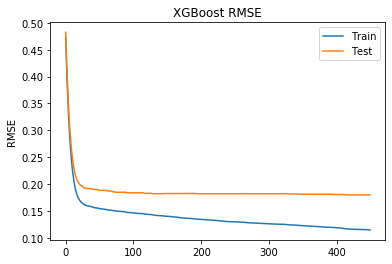

In [24]:
# Create eval_set
eval_set = [(X_train_2, y_train_2), (X_test_2, y_test_2)]

# Fit our model to the training set
best_model.fit(X_train_2, y_train_2, eval_set=eval_set, verbose=False)

# Make predictions with test data
y_pred = best_model.predict(X_test_2)
predictions = [round(value) for value in y_pred]

# Retrieve performance metrics
results = best_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot log loss curve
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')

## 10. Early stopping

In [25]:
best_model.fit(X_train_2, y_train_2, early_stopping_rounds=10, eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:0.472777	validation_1-rmse:0.482396
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.4317	validation_1-rmse:0.442451
[2]	validation_0-rmse:0.395316	validation_1-rmse:0.407245
[3]	validation_0-rmse:0.363161	validation_1-rmse:0.376325
[4]	validation_0-rmse:0.334828	validation_1-rmse:0.349246
[5]	validation_0-rmse:0.310009	validation_1-rmse:0.32576
[6]	validation_0-rmse:0.288214	validation_1-rmse:0.305372
[7]	validation_0-rmse:0.26935	validation_1-rmse:0.287811
[8]	validation_0-rmse:0.252838	validation_1-rmse:0.272815
[9]	validation_0-rmse:0.238604	validation_1-rmse:0.259646
[10]	validation_0-rmse:0.226473	validation_1-rmse:0.248802
[11]	validation_0-rmse:0.216174	validation_1-rmse:0.239581
[12]	validation_0-rmse:0.207337	validation_1-rmse:0.231705
[13]	validation_0-rmse:0.199757	validation_1-rmse:0.225293
[14]	validation_0-rmse:0.1928

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, max_features=1.0, min_child_weight=1,
             min_samples_leaf=5, missing=None, n_estimators=450, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)